# Hope Classification Model Comparison

This notebook compares three transformer-based models for hope classification:
- **BERT**: Bidirectional Encoder Representations from Transformers
- **GPT-2**: Generative Pre-trained Transformer 2
- **DeBERTa**: Decoding-enhanced BERT with Disentangled Attention

# Model Comparison

### | Model | Key Features | Advantages | Disadvantages
- |BERT | Bidirectional context | - Well-balanced<br>- Mature ecosystem | - Smaller context window |
- |GPT-2 | Autoregressive | - Strong language modeling<br>- Large pretraining corpus | - Unidirectional attention<br>- Higher compute requirements |
- | DeBERTa | Disentangled attention | - State-of-the-art accuracy<br>- Better handles complex expressions | - Most computationally expensive<br>- Complex architecture |


In [1]:
import pandas as pd
import tensorflow as tf
from transformers import (BertTokenizer, TFBertForSequenceClassification,
                         GPT2Tokenizer, TFGPT2ForSequenceClassification,
                         DebertaTokenizer, TFDebertaForSequenceClassification)
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import time

In [2]:
# Create directories for models and results
os.makedirs('./models', exist_ok=True)
os.makedirs('./results', exist_ok=True)

In [3]:
# Load data
train_df = pd.read_csv('/content/en_train.csv')
test_df = pd.read_csv('/content/en_dev.csv')

In [4]:
# Basic cleaning
def clean_text(text):
    import re
    text = text.lower()
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'#\w+|\@\w+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text

train_df['clean_text'] = train_df['text'].apply(clean_text)
test_df['clean_text'] = test_df['text'].apply(clean_text)

# Display data info
print("Train dataset shape:", train_df.shape)
print("Test dataset shape:", test_df.shape)
display(train_df.head(2))

Train dataset shape: (5233, 4)
Test dataset shape: (1902, 4)


,text,binary,multiclass,clean_text
0,#USER# #USER# #USER# #USER# You expect a man t...,Not Hope,Not Hope,you expect a man that literally refers to ...
1,#USER# #USER# #USER# #USER# Tinubu is actually...,Not Hope,Not Hope,tinubu is actually a bonus lols \n\nhis on...


In [5]:
# Split training data into train and validation sets
train_texts, val_texts, train_binary_labels, val_binary_labels = train_test_split(
    train_df['clean_text'], train_df['binary'], test_size=0.2, random_state=42
)
train_multi_labels, val_multi_labels = train_test_split(
    train_df['multiclass'], test_size=0.2, random_state=42
)

# Label mapping
binary_label_map = {'Not Hope': 0, 'Hope': 1}
multi_label_map = {'Not Hope': 0, 'Generalized Hope': 1, 'Realistic Hope': 2,
                   'Unrealistic Hope': 3, 'Sarcasm': 4}

y_train_binary = train_binary_labels.map(binary_label_map)
y_val_binary = val_binary_labels.map(binary_label_map)
y_test_binary = test_df['binary'].map(binary_label_map)
y_train_multi = train_multi_labels.map(multi_label_map)
y_val_multi = val_multi_labels.map(multi_label_map)
y_test_multi = test_df['multiclass'].map(multi_label_map)

# Check label distributions
print("Binary label distribution:")
print(y_train_binary.value_counts())
print("\nMulticlass label distribution:")
print(y_train_multi.value_counts())

Binary label distribution:
binary
0    2213
1    1973
Name: count, dtype: int64

Multiclass label distribution:
multiclass
0    1763
1    1052
4     552
2     438
3     381
Name: count, dtype: int64


In [6]:
#Model Setup Functions
def setup_bert(num_labels=2):
    """Set up BERT model and tokenizer"""
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)
    return model, tokenizer

def setup_gpt2(num_labels=2):
    """Set up GPT-2 model and tokenizer"""
    tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
    # GPT-2 doesn't have a pad token by default
    tokenizer.pad_token = tokenizer.eos_token
    model = TFGPT2ForSequenceClassification.from_pretrained('gpt2', num_labels=num_labels)
    # Fix for GPT-2 pad token embedding
    model.config.pad_token_id = tokenizer.pad_token_id

    # Very important: Set use_cache to False to avoid the past_key_values error
    model.config.use_cache = False
    return model, tokenizer

def setup_deberta(num_labels=2):
    """Set up DeBERTa model and tokenizer"""
    tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-base')
    model = TFDebertaForSequenceClassification.from_pretrained('microsoft/deberta-base', num_labels=num_labels)
    return model, tokenizer

In [7]:
#Training and Evaluation Function

def train_and_evaluate(model, tokenizer, model_name, task='binary', epochs=3, batch_size=16):
    """
    Train and evaluate a model for either binary or multiclass classification

    Args:
        model: The model to train
        tokenizer: The tokenizer for encoding texts
        model_name: String name of the model (for saving and display)
        task: 'binary' or 'multiclass'
        epochs: Number of training epochs
        batch_size: Batch size for training

    Returns:
        accuracy: Test accuracy
        history: Training history
        predictions: Model predictions on test set
    """
    # Define number of labels based on task
    num_labels = 2 if task == 'binary' else 5

    # Prepare labels
    if task == 'binary':
        y_train = y_train_binary
        y_val = y_val_binary
        y_test = y_test_binary
    else:
        y_train = y_train_multi
        y_val = y_val_multi
        y_test = y_test_multi

    # Encode texts
    def encode_texts(texts, max_length=128):
        return tokenizer(texts.tolist(), padding=True, truncation=True,
                        max_length=max_length, return_tensors='tf')

    train_encodings = encode_texts(train_texts)
    val_encodings = encode_texts(val_texts)
    test_encodings = encode_texts(test_df['clean_text'])

    # Compile model
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=2e-5)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

    # Callback to save the best model
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        f'./models/{model_name}_{task}',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        save_format='tf'
    )

    # Create dataset - handle GPT-2 differently
    if 'gpt2' in model_name.lower():
        # For GPT-2, we need to create a custom TF Dataset with the correct structure
        train_dataset = tf.data.Dataset.from_tensor_slices((
            {"input_ids": train_encodings["input_ids"],
             "attention_mask": train_encodings["attention_mask"]},
            y_train
        )).shuffle(1000).batch(batch_size)

        val_dataset = tf.data.Dataset.from_tensor_slices((
            {"input_ids": val_encodings["input_ids"],
             "attention_mask": val_encodings["attention_mask"]},
            y_val
        )).batch(batch_size)

        # Training with Dataset API
        start_time = time.time()
        history = model.fit(
            train_dataset,
            validation_data=val_dataset,
            epochs=epochs,
            callbacks=[checkpoint],
            verbose=1
        )

        # Predict with correct structure
        test_dataset = tf.data.Dataset.from_tensor_slices({
            "input_ids": test_encodings["input_ids"],
            "attention_mask": test_encodings["attention_mask"]
        }).batch(batch_size)
        pred = model.predict(test_dataset)
    else:
        # Regular training for BERT and DeBERTa
        start_time = time.time()
        history = model.fit(
            [train_encodings['input_ids'], train_encodings['attention_mask']],
            y_train,
            validation_data=([val_encodings['input_ids'], val_encodings['attention_mask']], y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[checkpoint],
            verbose=1
        )

        # Regular prediction
        pred = model.predict([test_encodings['input_ids'], test_encodings['attention_mask']])

    training_time = time.time() - start_time

    # Process predictions
    pred_labels = tf.argmax(pred.logits, axis=1)
    accuracy = accuracy_score(y_test, pred_labels)
    report = classification_report(y_test, pred_labels, output_dict=True)

    print(f"{model_name} {task.capitalize()} Accuracy: {accuracy:.4f}")
    print(f"Training time: {training_time:.2f} seconds")

    return {
        'accuracy': accuracy,
        'history': history,
        'predictions': pred_labels,
        'report': report,
        'training_time': training_time
    }

In [8]:
# Train Models (Binary Classification)


# Dictionary to store all results
results = {}

# BERT Binary
print("Training BERT Binary Classifier...")
model_bert_binary, tokenizer_bert = setup_bert(num_labels=2)
results['bert_binary'] = train_and_evaluate(model_bert_binary, tokenizer_bert, 'bert', task='binary')
tokenizer_bert.save_pretrained('./models/bert_tokenizer')

# GPT-2 Binary
print("Training GPT-2 Binary Classifier...")
model_gpt2_binary, tokenizer_gpt2 = setup_gpt2(num_labels=2)
results['gpt2_binary'] = train_and_evaluate(model_gpt2_binary, tokenizer_gpt2, 'gpt2', task='binary')
tokenizer_gpt2.save_pretrained('./models/gpt2_tokenizer')

# DeBERTa Binary
print("Training DeBERTa Binary Classifier...")
model_deberta_binary, tokenizer_deberta = setup_deberta(num_labels=2)
results['deberta_binary'] = train_and_evaluate(model_deberta_binary, tokenizer_deberta, 'deberta', task='binary')
tokenizer_deberta.save_pretrained('./models/deberta_tokenizer')


Training BERT Binary Classifier...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
262/262 [==============================] - 180s 596ms/step - loss: 0.4296 - accuracy: 0.7993 - val_loss: 0.2822 - val_accuracy: 0.8825
Epoch 2/3
262/262 [==============================] - 119s 455ms/step - loss: 0.2405 - accuracy: 0.9064 - val_loss: 0.3414 - val_accuracy: 0.8758
Epoch 3/3
60/60 [==============================] - 20s 276ms/step
bert Binary Accuracy: 0.8449
Training time: 443.17 seconds
Training GPT-2 Binary Classifier...


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFGPT2ForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFGPT2ForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
262/262 [==============================] - 178s 606ms/step - loss: 0.8478 - accuracy: 0.6266 - val_loss: 0.6191 - val_accuracy: 0.6819
Epoch 2/3
262/262 [==============================] - 165s 630ms/step - loss: 0.4033 - accuracy: 0.8235 - val_loss: 0.5212 - val_accuracy: 0.7631
Epoch 3/3
119/119 [==============================] - 21s 147ms/step
gpt2 Binary Accuracy: 0.7934
Training time: 526.93 seconds
Training DeBERTa Binary Classifier...


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/474 [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/555M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFDebertaForSequenceClassification.

Some layers of TFDebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['pooler', 'classifier', 'cls_dropout']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


262/262 [==============================] - 322s 1s/step - loss: 0.4230 - accuracy: 0.8055 - val_loss: 0.2846 - val_accuracy: 0.8749
Epoch 2/3
262/262 [==============================] - 177s 677ms/step - loss: 0.2699 - accuracy: 0.8932 - val_loss: 0.3265 - val_accuracy: 0.8634
Epoch 3/3
60/60 [==============================] - 27s 312ms/step
deberta Binary Accuracy: 0.8070
Training time: 703.67 seconds


('./models/deberta_tokenizer/tokenizer_config.json',
 './models/deberta_tokenizer/special_tokens_map.json',
 './models/deberta_tokenizer/vocab.json',
 './models/deberta_tokenizer/merges.txt',
 './models/deberta_tokenizer/added_tokens.json')

In [9]:
# Train Models (Multiclass Classification)

# BERT Multiclass
print("Training BERT Multiclass Classifier...")
model_bert_multi, _ = setup_bert(num_labels=5)
results['bert_multi'] = train_and_evaluate(model_bert_multi, tokenizer_bert, 'bert', task='multiclass')

# GPT-2 Multiclass
print("Training GPT-2 Multiclass Classifier...")
model_gpt2_multi, _ = setup_gpt2(num_labels=5)
results['gpt2_multi'] = train_and_evaluate(model_gpt2_multi, tokenizer_gpt2, 'gpt2', task='multiclass')

# DeBERTa Multiclass
print("Training DeBERTa Multiclass Classifier...")
model_deberta_multi, _ = setup_deberta(num_labels=5)
results['deberta_multi'] = train_and_evaluate(model_deberta_multi, tokenizer_deberta, 'deberta', task='multiclass')


Training BERT Multiclass Classifier...


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
262/262 [==============================] - 179s 618ms/step - loss: 1.1194 - accuracy: 0.5609 - val_loss: 0.8599 - val_accuracy: 0.6800
Epoch 2/3
262/262 [==============================] - 169s 644ms/step - loss: 0.6598 - accuracy: 0.7654 - val_loss: 0.6726 - val_accuracy: 0.7574
Epoch 3/3
60/60 [==============================] - 20s 276ms/step
bert Multiclass Accuracy: 0.7203
Training time: 539.24 seconds
Training GPT-2 Multiclass Classifier...


All PyTorch model weights were used when initializing TFGPT2ForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFGPT2ForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
262/262 [==============================] - 185s 637ms/step - loss: 1.4995 - accuracy: 0.4572 - val_loss: 1.1302 - val_accuracy: 0.5893
Epoch 2/3
262/262 [==============================] - 172s 658ms/step - loss: 0.9469 - accuracy: 0.6419 - val_loss: 0.7708 - val_accuracy: 0.7144
Epoch 3/3
119/119 [==============================] - 21s 148ms/step
gpt2 Multiclass Accuracy: 0.7129
Training time: 529.69 seconds
Training DeBERTa Multiclass Classifier...


All model checkpoint layers were used when initializing TFDebertaForSequenceClassification.

Some layers of TFDebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['pooler', 'classifier', 'cls_dropout']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
262/262 [==============================] - 387s 1s/step - loss: 1.3606 - accuracy: 0.4720 - val_loss: 0.9288 - val_accuracy: 0.6285
Epoch 2/3
262/262 [==============================] - 365s 1s/step - loss: 0.9917 - accuracy: 0.6300 - val_loss: 0.7015 - val_accuracy: 0.7479
Epoch 3/3
60/60 [==============================] - 26s 312ms/step
deberta Multiclass Accuracy: 0.7156
Training time: 947.88 seconds


In [10]:
# Compare accuracies
binary_accuracies = {
    'BERT': results['bert_binary']['accuracy'],
    'GPT-2': results['gpt2_binary']['accuracy'],
    'DeBERTa': results['deberta_binary']['accuracy']
}

multi_accuracies = {
    'BERT': results['bert_multi']['accuracy'],
    'GPT-2': results['gpt2_multi']['accuracy'],
    'DeBERTa': results['deberta_multi']['accuracy']
}

# Training times
binary_times = {
    'BERT': results['bert_binary']['training_time'],
    'GPT-2': results['gpt2_binary']['training_time'],
    'DeBERTa': results['deberta_binary']['training_time']
}

multi_times = {
    'BERT': results['bert_multi']['training_time'],
    'GPT-2': results['gpt2_multi']['training_time'],
    'DeBERTa': results['deberta_multi']['training_time']
}


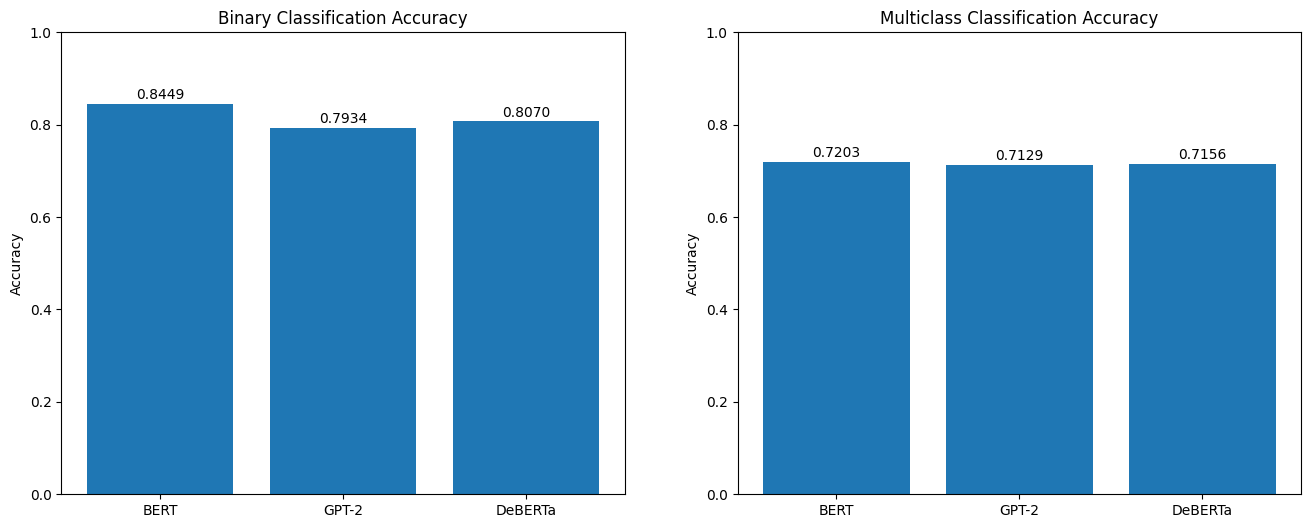

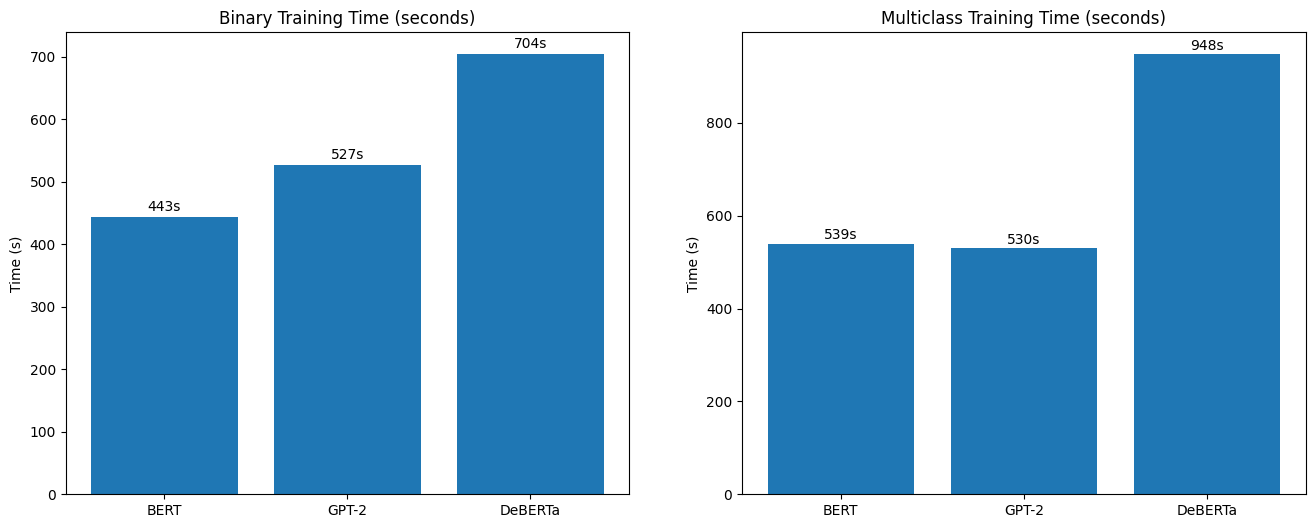

In [11]:
# Plot accuracy comparison
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Binary accuracy
ax[0].bar(binary_accuracies.keys(), binary_accuracies.values())
ax[0].set_ylim([0, 1])
ax[0].set_title('Binary Classification Accuracy')
ax[0].set_ylabel('Accuracy')
for i, v in enumerate(binary_accuracies.values()):
    ax[0].text(i, v + 0.01, f'{v:.4f}', ha='center')

# Multiclass accuracy
ax[1].bar(multi_accuracies.keys(), multi_accuracies.values())
ax[1].set_ylim([0, 1])
ax[1].set_title('Multiclass Classification Accuracy')
ax[1].set_ylabel('Accuracy')
for i, v in enumerate(multi_accuracies.values()):
    ax[1].text(i, v + 0.01, f'{v:.4f}', ha='center')

plt.savefig('./results/accuracy_comparison.png')
plt.show()

# Plot training time comparison
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Binary training time
ax[0].bar(binary_times.keys(), binary_times.values())
ax[0].set_title('Binary Training Time (seconds)')
ax[0].set_ylabel('Time (s)')
for i, v in enumerate(binary_times.values()):
    ax[0].text(i, v + 10, f'{v:.0f}s', ha='center')

# Multiclass training time
ax[1].bar(multi_times.keys(), multi_times.values())
ax[1].set_title('Multiclass Training Time (seconds)')
ax[1].set_ylabel('Time (s)')
for i, v in enumerate(multi_times.values()):
    ax[1].text(i, v + 10, f'{v:.0f}s', ha='center')

plt.savefig('./results/training_time_comparison.png')
plt.show()


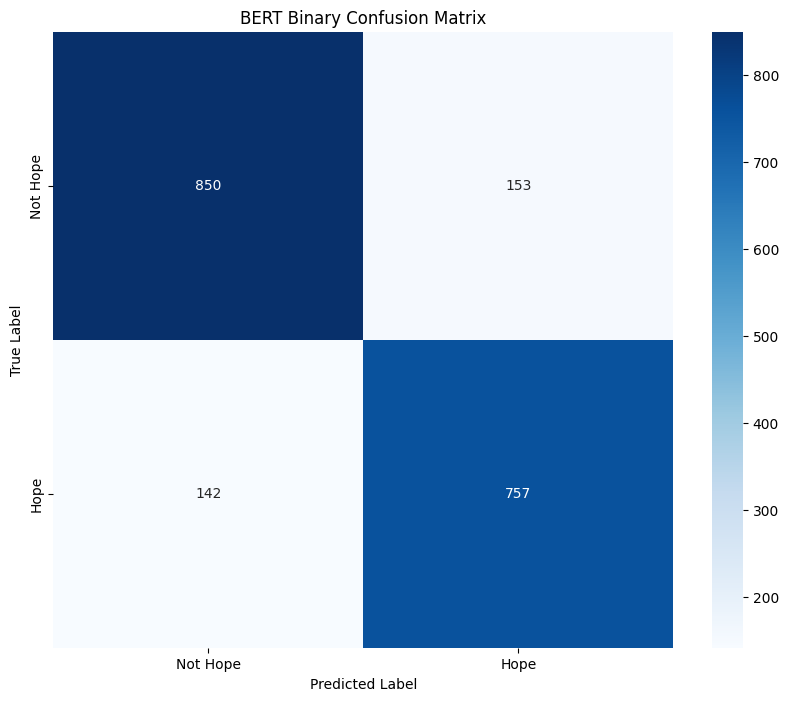

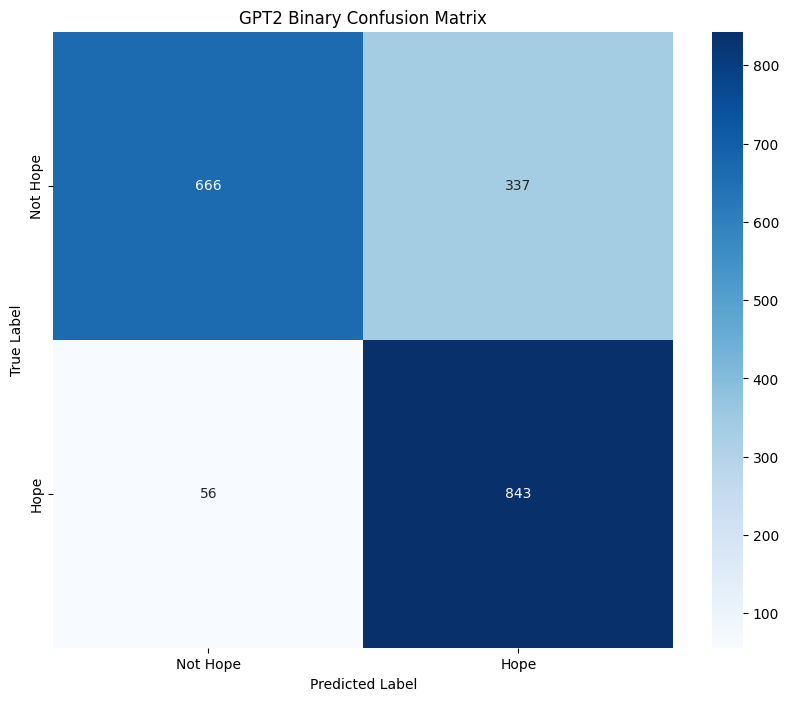

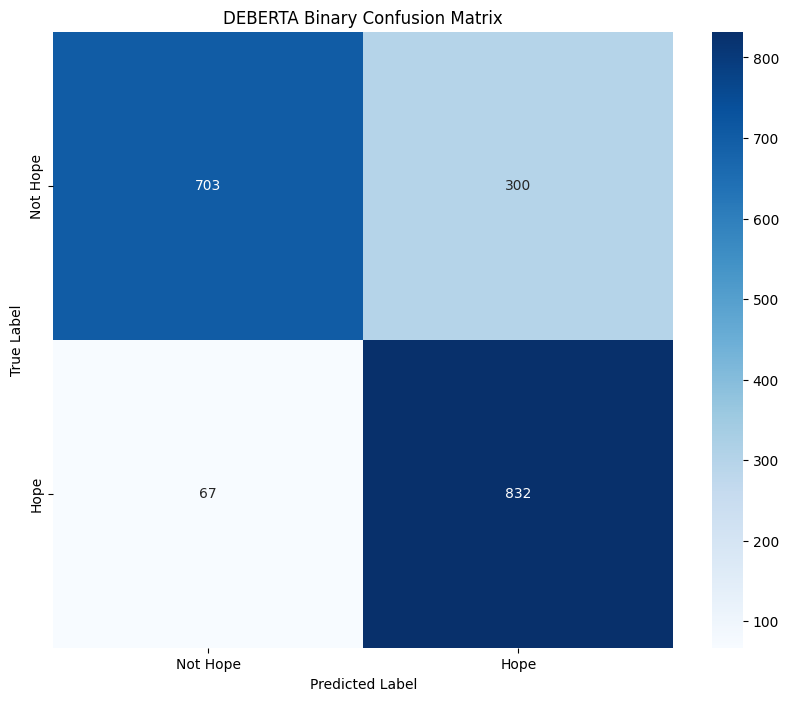

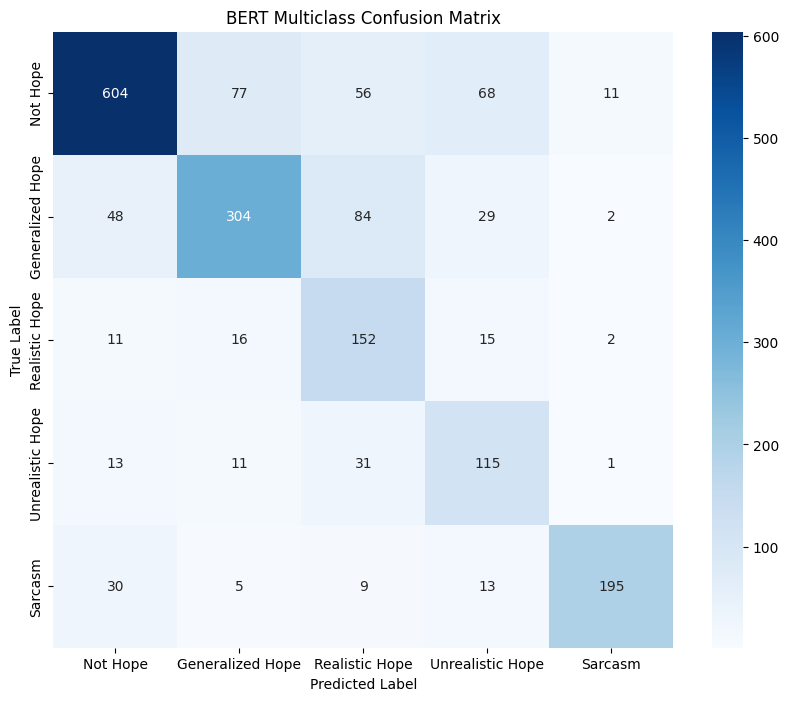

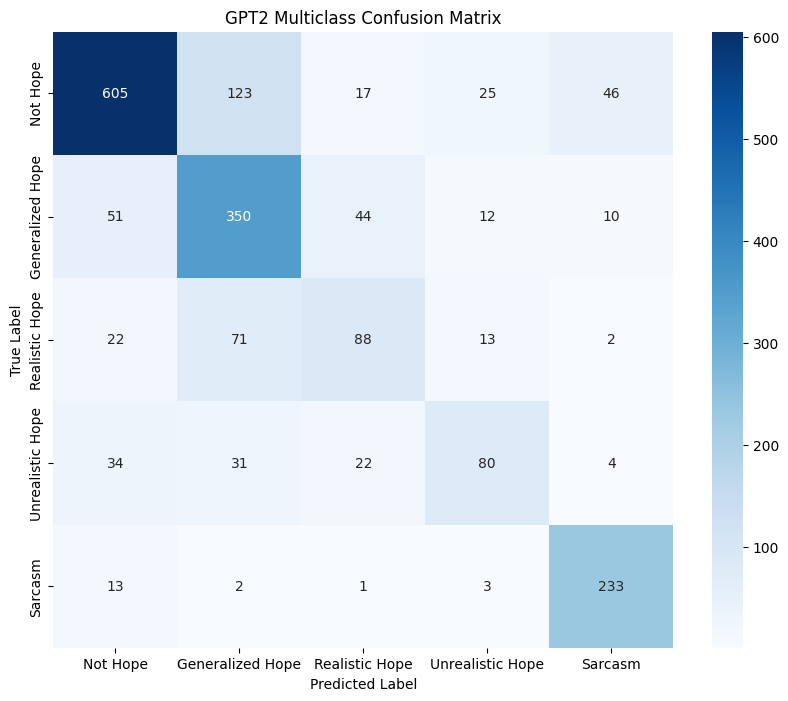

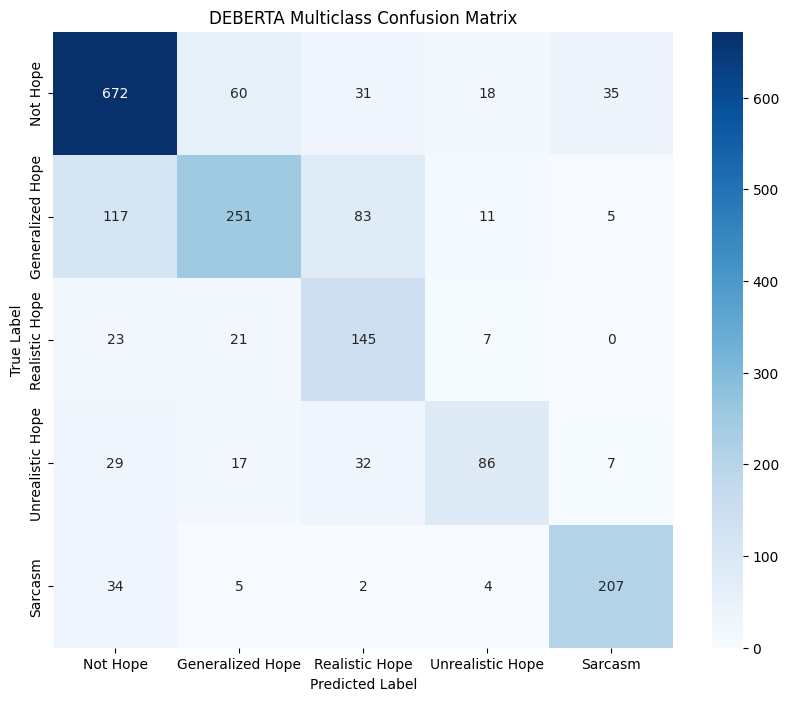

In [12]:
# Function to create confusion matrices
def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(f'./results/{title.replace(" ", "_").lower()}.png')
    plt.show()

# Binary confusion matrices
binary_classes = ['Not Hope', 'Hope']
for model_name in ['bert', 'gpt2', 'deberta']:
    plot_confusion_matrix(
        y_test_binary,
        results[f'{model_name}_binary']['predictions'],
        binary_classes,
        f'{model_name.upper()} Binary Confusion Matrix'
    )

# Multiclass confusion matrices
multi_classes = ['Not Hope', 'Generalized Hope', 'Realistic Hope', 'Unrealistic Hope', 'Sarcasm']
for model_name in ['bert', 'gpt2', 'deberta']:
    plot_confusion_matrix(
        y_test_multi,
        results[f'{model_name}_multi']['predictions'],
        multi_classes,
        f'{model_name.upper()} Multiclass Confusion Matrix'
    )

In [13]:
# Create a summary table with additional metrics
summary_table = pd.DataFrame({
    'Model': ['BERT Binary', 'GPT-2 Binary', 'DeBERTa Binary',
              'BERT Multiclass', 'GPT-2 Multiclass', 'DeBERTa Multiclass'],
    'W-Prec': [results['bert_binary']['report']['weighted avg']['precision'],
               results['gpt2_binary']['report']['weighted avg']['precision'],
               results['deberta_binary']['report']['weighted avg']['precision'],
               results['bert_multi']['report']['weighted avg']['precision'],
               results['gpt2_multi']['report']['weighted avg']['precision'],
               results['deberta_multi']['report']['weighted avg']['precision']],
    'W-Rec': [results['bert_binary']['report']['weighted avg']['recall'],
              results['gpt2_binary']['report']['weighted avg']['recall'],
              results['deberta_binary']['report']['weighted avg']['recall'],
              results['bert_multi']['report']['weighted avg']['recall'],
              results['gpt2_multi']['report']['weighted avg']['recall'],
              results['deberta_multi']['report']['weighted avg']['recall']],
    'W-F1': [results['bert_binary']['report']['weighted avg']['f1-score'],
             results['gpt2_binary']['report']['weighted avg']['f1-score'],
             results['deberta_binary']['report']['weighted avg']['f1-score'],
             results['bert_multi']['report']['weighted avg']['f1-score'],
             results['gpt2_multi']['report']['weighted avg']['f1-score'],
             results['deberta_multi']['report']['weighted avg']['f1-score']],
    'M-Prec': [results['bert_binary']['report']['macro avg']['precision'],
               results['gpt2_binary']['report']['macro avg']['precision'],
               results['deberta_binary']['report']['macro avg']['precision'],
               results['bert_multi']['report']['macro avg']['precision'],
               results['gpt2_multi']['report']['macro avg']['precision'],
               results['deberta_multi']['report']['macro avg']['precision']],
    'M-Rec': [results['bert_binary']['report']['macro avg']['recall'],
              results['gpt2_binary']['report']['macro avg']['recall'],
              results['deberta_binary']['report']['macro avg']['recall'],
              results['bert_multi']['report']['macro avg']['recall'],
              results['gpt2_multi']['report']['macro avg']['recall'],
              results['deberta_multi']['report']['macro avg']['recall']],
    'M-F1': [results['bert_binary']['report']['macro avg']['f1-score'],
             results['gpt2_binary']['report']['macro avg']['f1-score'],
             results['deberta_binary']['report']['macro avg']['f1-score'],
             results['bert_multi']['report']['macro avg']['f1-score'],
             results['gpt2_multi']['report']['macro avg']['f1-score'],
             results['deberta_multi']['report']['macro avg']['f1-score']],
    'Acc': [results['bert_binary']['accuracy'],
            results['gpt2_binary']['accuracy'],
            results['deberta_binary']['accuracy'],
            results['bert_multi']['accuracy'],
            results['gpt2_multi']['accuracy'],
            results['deberta_multi']['accuracy']],
    'Training Time (s)': [results['bert_binary']['training_time'],
                          results['gpt2_binary']['training_time'],
                          results['deberta_binary']['training_time'],
                          results['bert_multi']['training_time'],
                          results['gpt2_multi']['training_time'],
                          results['deberta_multi']['training_time']]
})

# Display the table with formatted values (round to 4 decimal places)
pd.set_option('display.float_format', '{:.4f}'.format)
display(summary_table.sort_values('Acc', ascending=False))

# Save this detailed table to CSV
summary_table.to_csv('./results/model_comparison_metrics.csv', index=False)

# Save detailed results to text file
with open('./results/comparison_results.txt', 'w') as f:
    f.write("# Binary Classification Results\n\n")
    for model in ['bert', 'gpt2', 'deberta']:
        f.write(f"## {model.upper()} Binary Results\n")
        f.write(f"Accuracy: {results[f'{model}_binary']['accuracy']:.4f}\n")
        f.write(f"Training Time: {results[f'{model}_binary']['training_time']:.2f} seconds\n\n")
        f.write("Classification Report:\n")
        for label, metrics in results[f'{model}_binary']['report'].items():
            if label in ['0', '1']:
                label_name = 'Not Hope' if label == '0' else 'Hope'
                f.write(f"  {label_name}: ")
                f.write(f"Precision: {metrics['precision']:.4f}, ")
                f.write(f"Recall: {metrics['recall']:.4f}, ")
                f.write(f"F1: {metrics['f1-score']:.4f}, ")
                f.write(f"Support: {metrics['support']}\n")
        f.write("\n\n")

    f.write("# Multiclass Classification Results\n\n")
    for model in ['bert', 'gpt2', 'deberta']:
        f.write(f"## {model.upper()} Multiclass Results\n")
        f.write(f"Accuracy: {results[f'{model}_multi']['accuracy']:.4f}\n")
        f.write(f"Training Time: {results[f'{model}_multi']['training_time']:.2f} seconds\n\n")
        f.write("Classification Report:\n")
        for label, metrics in results[f'{model}_multi']['report'].items():
            if label in ['0', '1', '2', '3', '4']:
                label_map = {
                    '0': 'Not Hope',
                    '1': 'Generalized Hope',
                    '2': 'Realistic Hope',
                    '3': 'Unrealistic Hope',
                    '4': 'Sarcasm'
                }
                label_name = label_map[label]
                f.write(f"  {label_name}: ")
                f.write(f"Precision: {metrics['precision']:.4f}, ")
                f.write(f"Recall: {metrics['recall']:.4f}, ")
                f.write(f"F1: {metrics['f1-score']:.4f}, ")
                f.write(f"Support: {metrics['support']}\n")
        f.write("\n\n")

print("Comparison completed. Results saved to './results' directory.")

,Model,W-Prec,W-Rec,W-F1,M-Prec,M-Rec,M-F1,Acc,Training Time (s)
0,BERT Binary,0.8450,0.8449,0.8449,0.8444,0.8448,0.8445,0.8449,443.1695
2,DeBERTa Binary,0.8289,0.8070,0.8054,0.8240,0.8132,0.8062,0.8070,703.6702
1,GPT-2 Binary,0.8241,0.7934,0.7905,0.8184,0.8009,0.7916,0.7934,526.9318
3,BERT Multiclass,0.7605,0.7203,0.7314,0.6906,0.7226,0.6925,0.7203,539.2354
5,DeBERTa Multiclass,0.7239,0.7156,0.7127,0.6939,0.6850,0.6793,0.7156,947.8831
4,GPT-2 Multiclass,0.7184,0.7129,0.7110,0.6688,0.6665,0.6624,0.7129,529.6870


Comparison completed. Results saved to './results' directory.
